## Imports and inits

In [1]:
import os
import pandas as pd
import numpy as np
import pyneb as pn
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from ai4neb import manage_RM
from pyneb.core.pynebcore import getHbEmissivity
from sqlalchemy import create_engine
from obs_int import get_obs_int
from diagnostics import get_TeNe
from ionic_abund import set_abunds
import joblib

2024-06-25 12:14:00.372005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 12:14:00.455234: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 12:14:00.458141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-25 12:14:00.458156: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
data_dir = "CSVs/"

## Get the 3MdB PN data

In [3]:
def get_3MdB(data_file, force=False):
    """
    This function is used to download the data from 3MdB. They are stored in data_dir + data_file.
    The axxx parameters are ionic abundance ratios, the ixxx parameters are ICFs
    """

    if not os.path.exists(data_dir + data_file) or force:
        sel = """SELECT atm1 as Teff,
            OXYGEN,
            MassFrac,
            logU_mean as logU,
            A_HELIUM_vol_2 / (A_HELIUM_vol_1 + A_HELIUM_vol_2) as ahe21,
            A_OXYGEN_vol_2 / (A_OXYGEN_vol_1 + A_OXYGEN_vol_2) as ao21,
            A_SULPHUR_vol_2/ (A_SULPHUR_vol_1 + A_SULPHUR_vol_2) as as21,
            A_CHLORINE_vol_3/(A_CHLORINE_vol_2 + A_CHLORINE_vol_3) as acl32,
            A_ARGON_vol_3 / (A_ARGON_vol_2 + A_ARGON_vol_3) as aar32,
            A_OXYGEN_vol_1 / A_NITROGEN_vol_1 as inO1, 
            A_OXYGEN_vol_1 / (A_SULPHUR_vol_1 + A_SULPHUR_vol_2) as isO21,
            (A_OXYGEN_vol_1 + A_OXYGEN_vol_2) /(A_SULPHUR_vol_1 + A_SULPHUR_vol_2) as is21O21,
            A_OXYGEN_vol_1 / A_CHLORINE_vol_2 as iclO2, 
            (A_OXYGEN_vol_1 + A_OXYGEN_vol_2) / A_ARGON_vol_2 as iarO2,
            1/A_NITROGEN_vol_1 as in1,
            1/(A_OXYGEN_vol_1 + A_OXYGEN_vol_2) as io21,
            1/(A_SULPHUR_vol_1 + A_SULPHUR_vol_2) as is21,
            1/A_CHLORINE_vol_2 as icl2,
            1/(A_CHLORINE_vol_2 + A_CHLORINE_vol_3) as icl32,
            1/(A_ARGON_vol_2 + A_ARGON_vol_3) as iar32,
            A_CHLORINE_vol_2/A_SULPHUR_vol_2 as iclar2
            FROM tab_17, abion_17
            WHERE tab_17.N=abion_17.N
            AND com6 = 1 
            AND MassFrac > 0.7
            AND tab_17.ref like 'PNe_202_' """
        user = os.environ["MdB_USER"]
        host = os.environ["MdB_HOST"]
        passwd = os.environ["MdB_PASSWD"]
        db = os.environ["MdB_DB_17"]
        port = os.environ['MdB_PORT']
        sqlEngine = create_engine(f"mysql+pymysql://{user}:{passwd}@{host}:{port}/{db}")
        with sqlEngine.connect() as db_con:
            data = pd.read_sql(sel, con=db_con)
        for var in ("Teff",):
            data[var] = data[var].astype("float64")
        # log(ICF - 1) are also defined, easier for the ANN training
        for s in ["in1", "io21", "is21", "icl32", "icl2", "iar32"]:
            data["l_" + s] = np.log10(data[s] - 1)
        for s in ["inO1", "isO21", "iarO2", "is21O21", "iclO2"]:
            data["l_" + s] = np.log10(data[s])
        data.dropna(inplace=True)
        data.to_csv(data_dir + data_file, index=False)
    else:
        data = pd.read_csv(data_dir + data_file)
    print("length: ", len(data))
    return data

In [4]:
df = get_3MdB("3mdb_ICF.dat.gz", force=False)

length:  68038


In [5]:
ICF_str = {
    "in1": "ICF(N+)",
    "io21": "ICF(O+ + O++)",
    "is21": "ICF(S+ + S++)",
    "icl2": "ICF(Cl++)",
    "icl32": "ICF(Cl++ + Cl3+)",
    "iar32": "ICF(Ar++ + Ar3+)",
    "inO1": "ICF(N+/O+)",
    "isO21": "ICF(S+ + S++ / O+)",
    "is21O21": "ICF(S+ + S++) / (O+ + O++))",
    "iclO2": "ICF(Cl++ / O+)",
    "iarO2": "ICF(Ar++ / (O+ + O++))",
    "rio21": "ICF(O+ + O++)",
    "ico": "ICF(C+/O+)",
    "ikr3": "ICF(Kr3+)"
}

## Set observation data

In [6]:
def rap_ab(a1, a2):
    return 10**a2 / (10**a1 + 10**a2)


# Define some ionic abundance ratios from observations
obs = {
    "ahe21": rap_ab(
        np.log10(0.0892), np.log10(0.006)
    ),  # He++/H+: inventado entre el minimo 0 y el maximo 0.012.
    "ao21": rap_ab(7.61, 8.65),
    "as21": rap_ab(5.78, 6.95),
    "acl32": rap_ab(5.27, 4.76),
    "aar32": rap_ab(6.53, 6.02),
}

In [7]:
obs

{'ahe21': 0.06302521008403357,
 'ao21': 0.9164213770695134,
 'as21': 0.9366731246890521,
 'acl32': 0.23607530085516146,
 'aar32': 0.23607530085516107}

In [8]:
obs_int = get_obs_int()
TeNe_int, _ = get_TeNe(obs = obs_int, plot = False)
w_int = joblib.load('omega_mask.joblib')[0]
w_1_int = joblib.load('omega_1_mask.joblib')[0]

labels = ['He1r_5876A',
          'He2r_4686A',
          'C2r_6462.0A',
          'N1_5198A',
          'N2_6548A',
          'N2r_5679.56A',
          'O1_6300A',
          'O1r_7773+',
          'O2_7330A+',
          'O2r_4649.13A',
          'O2r_4661.63A',
          'O3_4959A',
          'S2_6731A',
          'S3_9069A',
          'Cl3_5538A',
          'Cl4_8046A',
          'Ar3_7136A',
          'Ar4_4740A',
          'Ar5_7005A', 
          'Kr4_5868A',
        ]
abund_r7 = {}

for label in labels:
    ab_r7 = set_abunds(TeNe_int, obs_int, label = label, exclude_elem=('H', ), Te_rec=2000, Ne_rec=10000, w = w_int,  w_1 = w_1_int,
                    tem_HI = 8300*np.ones_like(TeNe_int['N2S2']['Te']), tem_HI_RLs = None, consider_3zones = True, use_ar3 = False)
    abund_r7[label] = ab_r7[label]

warng EmissionLine: line 4641A for atom N3r not valid
4641A ['4641+', '4100+']
warng EmissionLine: line 7177A for atom He2r not valid
7177A ['1640A', '1215A', '1084A', '4686A', '3203A', '6560A', '5411A', '4859A', '4541A', '6407A', '4198A']
warng EmissionLine: line 7771A for atom O1r not valid
7771A ['8447+', '7773+', '9264+', '3947+', '1357+']
warng EmissionLine: line 7773A for atom O1r not valid
7773A ['8447+', '7773+', '9264+', '3947+', '1357+']
warng EmissionLine: line 7775A for atom O1r not valid
7775A ['8447+', '7773+', '9264+', '3947+', '1357+']
warng EmissionLine: line 8100A for atom H1r not valid
8100A ['1216A', '1026A', '973A', '6563A', '4861A', '4341A', '4102A', '3970A', '3889A', '3835A', '3798A', '1.87m', '1.28m', '1.09m', '9546A', '9229A', '8750A', '8863A', '9015A']
warng EmissionLine: line 8400A for atom H1r not valid
8400A ['1216A', '1026A', '973A', '6563A', '4861A', '4341A', '4102A', '3970A', '3889A', '3835A', '3798A', '1.87m', '1.28m', '1.09m', '9546A', '9229A', '8750A'

/home/vero/.cache/pypoetry/virtualenvs/ngc-muse-afNZkvwp-py3.10/lib/python3.10/site-packages/pyneb/core/pynebcore.py:4698: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data_tab = np.genfromtxt(obsFile, dtype=None, delimiter=delimiter, names=True)
/home/vero/.cache/pypoetry/virtualenvs/ngc-muse-afNZkvwp-py3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vero/.cache/pypoetry/virtualenvs/ngc-muse-afNZkvwp-py3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from ver

   None: ANN getCrossTemDen done in 0.04327726364135742
warng Atom He1: [1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-21 1.72042242e-21 1.72042242e-21 1.72042242e-21
 1.72042242e-

## Look for models that reproduce the abundance ratios within a given tolerance

In [9]:
abund_r7.keys()

dict_keys(['He1r_5876A', 'He2r_4686A', 'C2r_6462.0A', 'N1_5198A', 'N2_6548A', 'N2r_5679.56A', 'O1_6300A', 'O1r_7773+', 'O2_7330A+', 'O2r_4649.13A', 'O2r_4661.63A', 'O3_4959A', 'S2_6731A', 'S3_9069A', 'Cl3_5538A', 'Cl4_8046A', 'Ar3_7136A', 'Ar4_4740A', 'Ar5_7005A', 'Kr4_5868A'])

In [10]:
def get_ab_lims(label1,label2):
    ab1 = abund_r7[label1]
    ab2 = abund_r7[label2]
    ab21 = ab2/(ab1+ab2)
    return np.quantile(ab21, q = 0.05), np.quantile(ab21, q = 0.95)

In [11]:
masks = []
abund_strs = ("ao21", "as21", "acl32", "aar32")

tolerances = {"ao21":get_ab_lims('O2_7330A+','O3_4959A'), 
              "as21":get_ab_lims('S2_6731A', 'S3_9069A'), 
              "acl32":get_ab_lims('Cl3_5538A', 'Cl4_8046A'), 
               "aar32":get_ab_lims('Ar3_7136A', 'Ar4_4740A')}

for s in abund_strs:
    masks.append((df[s] > tolerances[s][0]) & (df[s]< tolerances[s][1]))
masks = np.asarray(masks)
mask = masks.all(0)
print(f"{masks.sum(1)} all together: {mask.sum()}")

[10917  6302  5022  7951] all together: 247


## Analyse the results

In [12]:
df.keys()

Index(['Teff', 'OXYGEN', 'MassFrac', 'logU', 'ahe21', 'ao21', 'as21', 'acl32',
       'aar32', 'inO1', 'isO21', 'is21O21', 'iclO2', 'iarO2', 'in1', 'io21',
       'is21', 'icl2', 'icl32', 'iar32', 'iclar2', 'l_in1', 'l_io21', 'l_is21',
       'l_icl32', 'l_icl2', 'l_iar32', 'l_inO1', 'l_isO21', 'l_iarO2',
       'l_is21O21', 'l_iclO2'],
      dtype='object')

In [13]:
# Analyse the results: the min and max of the ixxx parameters give the range of ICFs for the corresponding element.
# for example in1 dances between 8 and 27: N/H will be obtained by : in1 * N+/H+: big uncertainty.
# The other elements : O, S, Cl and Ar are not so badly determined
df[mask].describe()

,Teff,OXYGEN,MassFrac,logU,ahe21,ao21,as21,acl32,aar32,inO1,...,l_io21,l_is21,l_icl32,l_icl2,l_iar32,l_inO1,l_isO21,l_iarO2,l_is21O21,l_iclO2
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,...,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,64615.384615,-3.408639,0.849980,-2.008112,0.013860,0.900804,0.933182,0.243022,0.226398,1.245003,...,-2.057267,-0.464469,-1.318076,-0.415043,-1.967483,0.093691,-0.885988,0.111275,0.124116,-0.873613
std,7909.154297,0.682598,0.075968,0.242736,0.012881,0.016436,0.011037,0.016051,0.016392,0.103187,...,0.411376,0.071334,0.065695,0.036782,0.116680,0.035885,0.075838,0.009268,0.018254,0.077270
min,50000.000000,-5.464902,0.789311,-2.489690,0.000007,0.868795,0.914142,0.212166,0.199948,1.046904,...,-3.400047,-0.605509,-1.511873,-0.490861,-2.276821,0.019907,-1.107011,0.088679,0.091106,-1.108532
25%,60000.000000,-3.660000,0.794737,-2.158375,0.005929,0.888835,0.922845,0.228498,0.214183,1.154868,...,-2.149412,-0.508427,-1.349187,-0.446366,-2.031432,0.062532,-0.924270,0.104475,0.111730,-0.919320
50%,60000.000000,-3.360000,0.798124,-2.032370,0.009125,0.896884,0.934112,0.241590,0.221653,1.237503,...,-1.938285,-0.457540,-1.323484,-0.414701,-1.982058,0.092546,-0.867989,0.108792,0.123267,-0.852906
75%,70000.000000,-2.964902,0.898195,-1.891855,0.020998,0.911105,0.943797,0.256984,0.239046,1.343352,...,-1.772424,-0.418564,-1.270263,-0.383055,-1.867640,0.128190,-0.837227,0.117505,0.135676,-0.820248
max,90000.000000,-2.760000,1.000000,-1.160480,0.083775,0.942085,0.951923,0.270036,0.270016,1.498623,...,-1.411740,-0.281362,-1.184206,-0.346773,-1.733967,0.175692,-0.739959,0.135498,0.179048,-0.744053


In [14]:
df[mask][['inO1', 'isO21', 'is21O21', 'iclO2', 'iarO2', 'in1', 'io21',
       'is21', 'icl2', 'icl32', 'iar32', 'iclar2']].describe()

,inO1,isO21,is21O21,iclO2,iarO2,in1,io21,is21,icl2,icl32,iar32,iclar2
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,1.245003,0.131910,1.331987,0.135784,1.292330,13.092763,1.011909,1.347831,1.385928,1.048617,1.011174,1.042438
std,0.103187,0.021468,0.056498,0.022286,0.027776,2.707645,0.007284,0.057489,0.032614,0.007196,0.003060,0.043314
min,1.046904,0.078161,1.233406,0.077888,1.226532,9.267895,1.000398,1.248022,1.322953,1.030770,1.005287,0.978237
25%,1.154868,0.119050,1.293393,0.120415,1.271965,11.268820,1.007089,1.310151,1.357795,1.044752,1.009302,1.016987
50%,1.237503,0.135522,1.328212,0.140312,1.284671,12.382210,1.011527,1.348707,1.384856,1.047481,1.010422,1.040769
75%,1.343352,0.145470,1.366710,0.151270,1.310706,13.971625,1.016888,1.381449,1.413947,1.053671,1.013563,1.061210
max,1.498623,0.181987,1.510248,0.180280,1.366148,22.991974,1.038749,1.523164,1.450015,1.065433,1.018452,1.208155


## Train a ML to determine the ICFs from ab ratios

In [15]:
# Select models close (but not so close as before) to the observed point
tolerances = (0.5, 0.5, 0.5, 0.5, 0.1)
masks2 = []
abund_strs = ("ao21", "as21", "acl32", "aar32", "ahe21")
for t, s in zip(tolerances, abund_strs):
    masks2.append(np.abs(df[s] - obs[s]) < t)
masks2 = np.asarray(masks2)
mask2 = masks2.all(0)
print(f"{masks2.sum(1)} all together: {mask2.sum()}")

[57316 63156 68026 68038 29804] all together: 20945


In [16]:
df[mask2]["ahe21"].describe()

count    20945.000000
mean         0.047716
std          0.053112
min          0.000006
25%          0.001474
50%          0.023687
75%          0.088044
max          0.163017
Name: ahe21, dtype: float64

In [17]:
df.keys()

Index(['Teff', 'OXYGEN', 'MassFrac', 'logU', 'ahe21', 'ao21', 'as21', 'acl32',
       'aar32', 'inO1', 'isO21', 'is21O21', 'iclO2', 'iarO2', 'in1', 'io21',
       'is21', 'icl2', 'icl32', 'iar32', 'iclar2', 'l_in1', 'l_io21', 'l_is21',
       'l_icl32', 'l_icl2', 'l_iar32', 'l_inO1', 'l_isO21', 'l_iarO2',
       'l_is21O21', 'l_iclO2'],
      dtype='object')

In [18]:
X_strs = ["ahe21", "ao21", "as21", "acl32", "aar32"]
# We use for y the log10(ICF - 1) values: better to train the model.
y_strs = [
    "l_in1",
    "l_io21",
    "l_is21",
    "l_icl2",
    "l_icl32",
    "l_iar32",
    "l_inO1",
    "l_isO21",
    "l_is21O21",
    "l_iclO2",
    "l_iarO2",
]
X_train = df[X_strs][mask2]
y_train = df[y_strs][mask2]
RM = manage_RM(
    RM_type="SK_ANN",
    X_train=X_train,
    y_train=y_train,
    scaling=True,
    use_log=False,
    split_ratio=0.2,
    verbose=True,
    scaling_y=False,
    random_seed=42,
)
# Initialize the model
RM.init_RM(
    hidden_layer_sizes=(50, 80, 80),
)
RM.train_RM(scoring=False)
RM.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 16756, Test set size = 4189
Train data scaled. 
Test data scaled. 
Training set size = 16756, Test set size = 4189
Training set size = 16756, Test set size = 4189
Regression Model SK_ANN
Training 5 inputs for 11 outputs with 16756 data
MLPRegressor(hidden_layer_sizes=(50, 80, 80), random_state=42)
Training time 3.1 s.
Predicting from 5 inputs to 11 outputs using 4189 data in 0.01 secs.


ICF(N+) 0.12 +/- 1.38
ICF(O+ + O++) -0.00 +/- 0.01
ICF(S+ + S++) 0.01 +/- 0.04
ICF(Cl++) 0.00 +/- 0.03
ICF(Cl++ + Cl3+) 0.00 +/- 0.01
ICF(Ar++ + Ar3+) -0.00 +/- 0.02
ICF(N+/O+) -0.01 +/- 0.06
ICF(S+ + S++ / O+) 0.00 +/- 0.01
ICF(S+ + S++) / (O+ + O++)) -0.00 +/- 0.05
ICF(Cl++ / O+) 0.00 +/- 0.01
ICF(Ar++ / (O+ + O++)) 0.01 +/- 0.04


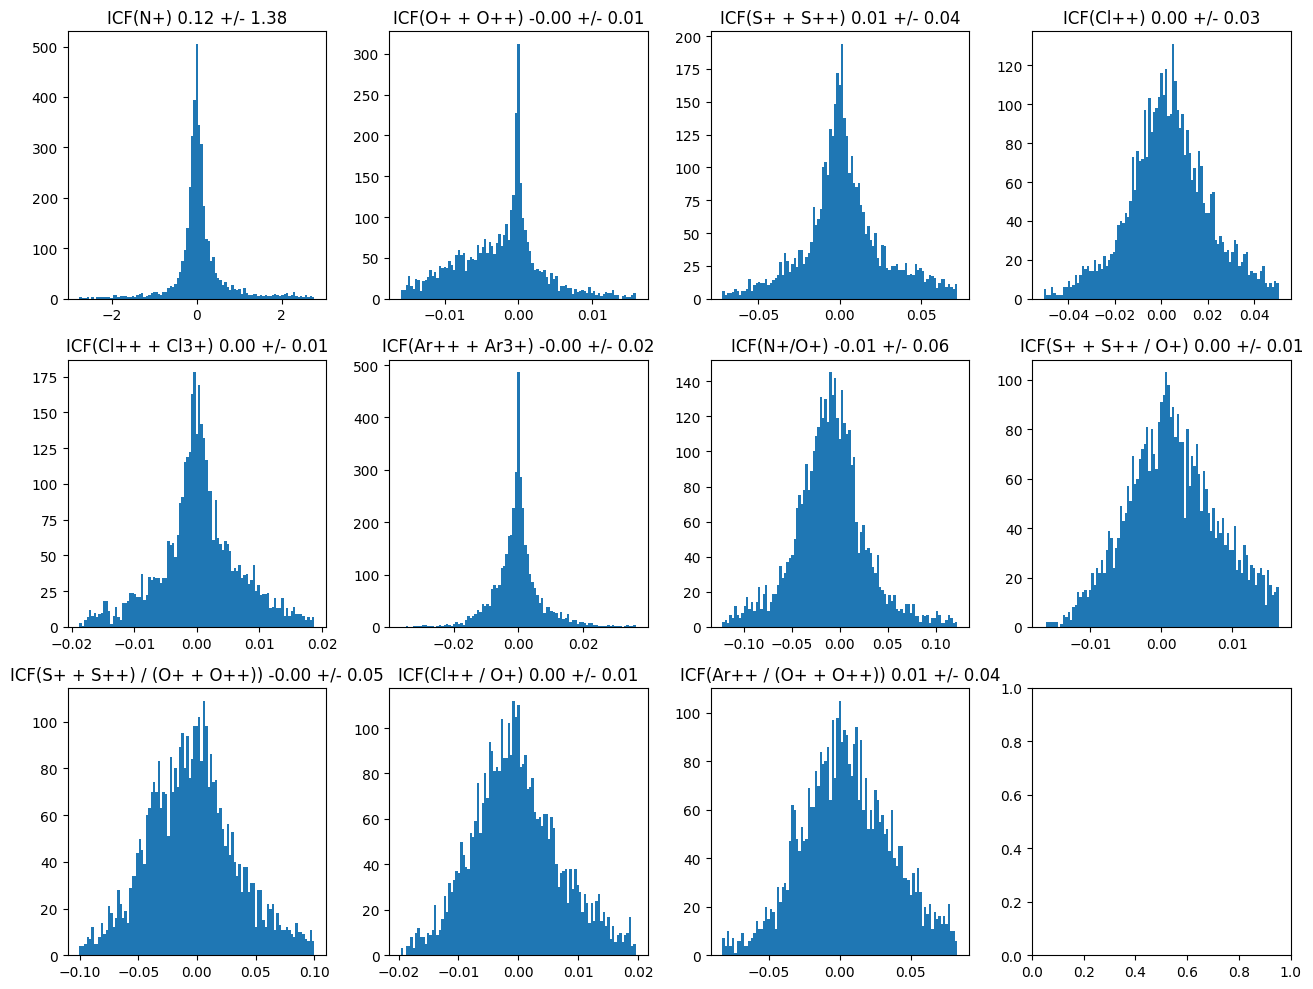

In [19]:
f, axes = plt.subplots(3, 4, figsize=(13, 10))

for i, y_str in enumerate(y_strs):
    diff = (10**RM.pred - 10**RM.y_test.values)[:, i]
    mean = np.mean(diff)
    std = np.std(diff)
    ax = axes.ravel()[i]
    ax.hist(diff, bins=np.linspace(-std * 2, std * 2, 100))
    tit = f"{ICF_str[y_str[2:]]} {mean:.2f} +/- {std:.2f}"
    ax.set_title(tit)
    print(tit)

f.tight_layout()

ICF(N+) 0.12 +/- 1.38
ICF(O+ + O++) -0.00 +/- 0.01
ICF(S+ + S++) 0.01 +/- 0.04
ICF(Cl++) 0.00 +/- 0.03
ICF(Cl++ + Cl3+) 0.00 +/- 0.01
ICF(Ar++ + Ar3+) -0.00 +/- 0.02
ICF(N+/O+) -0.01 +/- 0.06
ICF(S+ + S++ / O+) 0.00 +/- 0.01
ICF(S+ + S++) / (O+ + O++)) -0.00 +/- 0.05
ICF(Cl++ / O+) 0.00 +/- 0.01
ICF(Ar++ / (O+ + O++)) 0.01 +/- 0.04


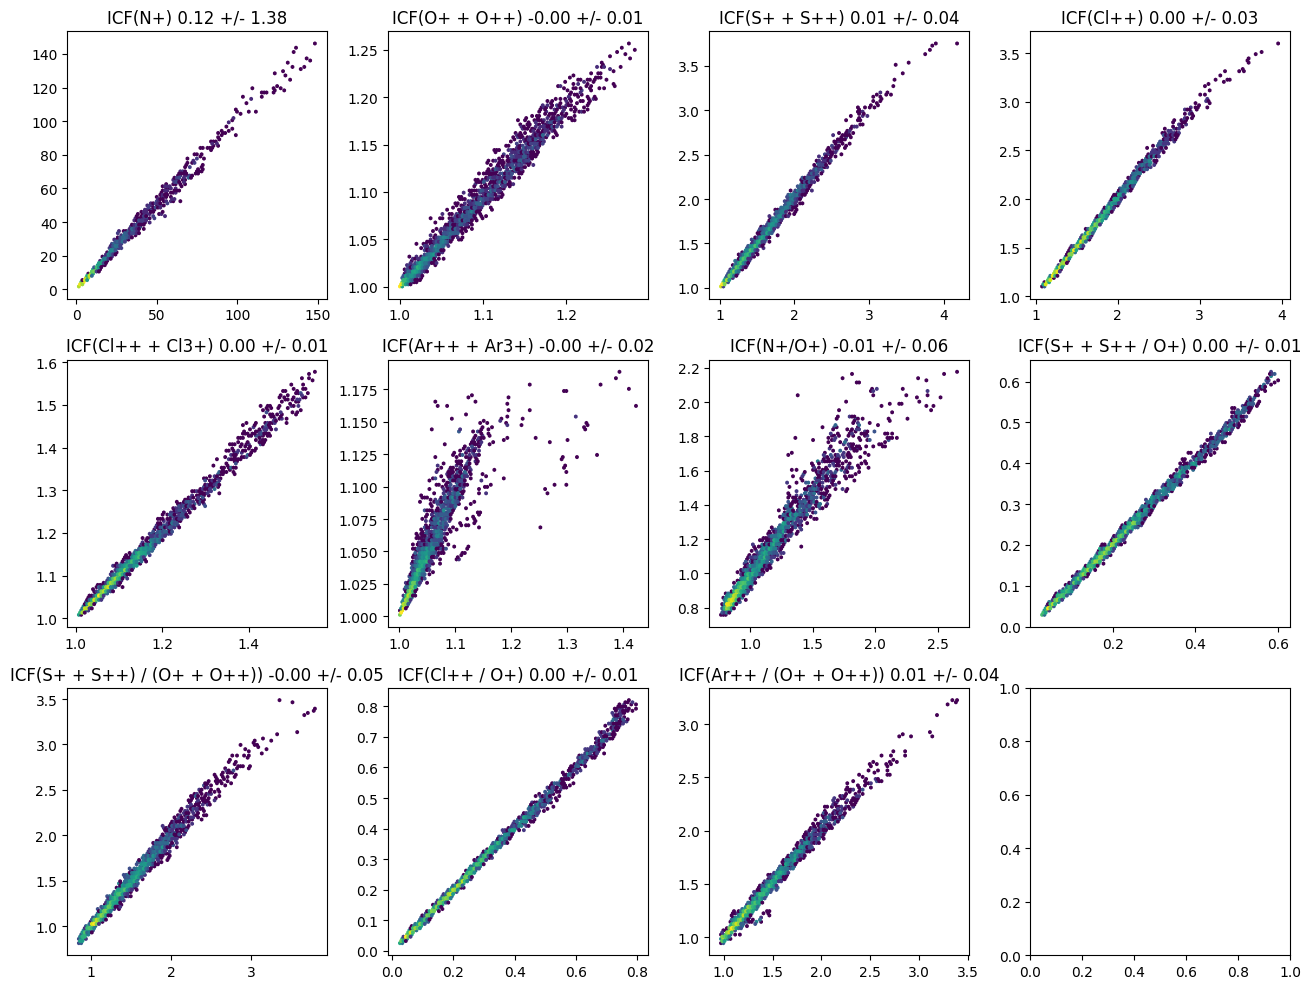

In [20]:
f, axes = plt.subplots(3, 4, figsize=(13, 10))

for i, y_str in enumerate(y_strs):
    diff = (10**RM.pred - 10**RM.y_test.values)[:, i]
    mean = np.mean(diff)
    std = np.std(diff)
    ax = axes.ravel()[i]
    if 'O' in y_str:
        ax.hexbin(10 ** RM.y_test.values[:, i], 10 ** RM.pred[:, i], bins="log")
    else:
        ax.hexbin(1 + 10 ** RM.y_test.values[:, i], 1 + 10 ** RM.pred[:, i], bins="log")
    tit = f"{ICF_str[y_str[2:]]} {mean:.2f} +/- {std:.2f}"
    ax.set_title(tit)
    print(tit)
f.tight_layout()

log(ICF(N+)-1) 0.00 +/- 0.03
log(ICF(O+ + O++)-1) -0.03 +/- 0.11
log(ICF(S+ + S++)-1) 0.00 +/- 0.05
log(ICF(Cl++)-1) 0.00 +/- 0.02
log(ICF(Cl++ + Cl3+)-1) 0.00 +/- 0.04
log(ICF(Ar++ + Ar3+)-1) -0.00 +/- 0.09
log(ICF(N+/O+)-1) -0.01 +/- 0.02
log(ICF(S+ + S++ / O+)-1) 0.00 +/- 0.02
log(ICF(S+ + S++) / (O+ + O++))-1) -0.00 +/- 0.01
log(ICF(Cl++ / O+)-1) -0.00 +/- 0.02
log(ICF(Ar++ / (O+ + O++))-1) 0.00 +/- 0.01


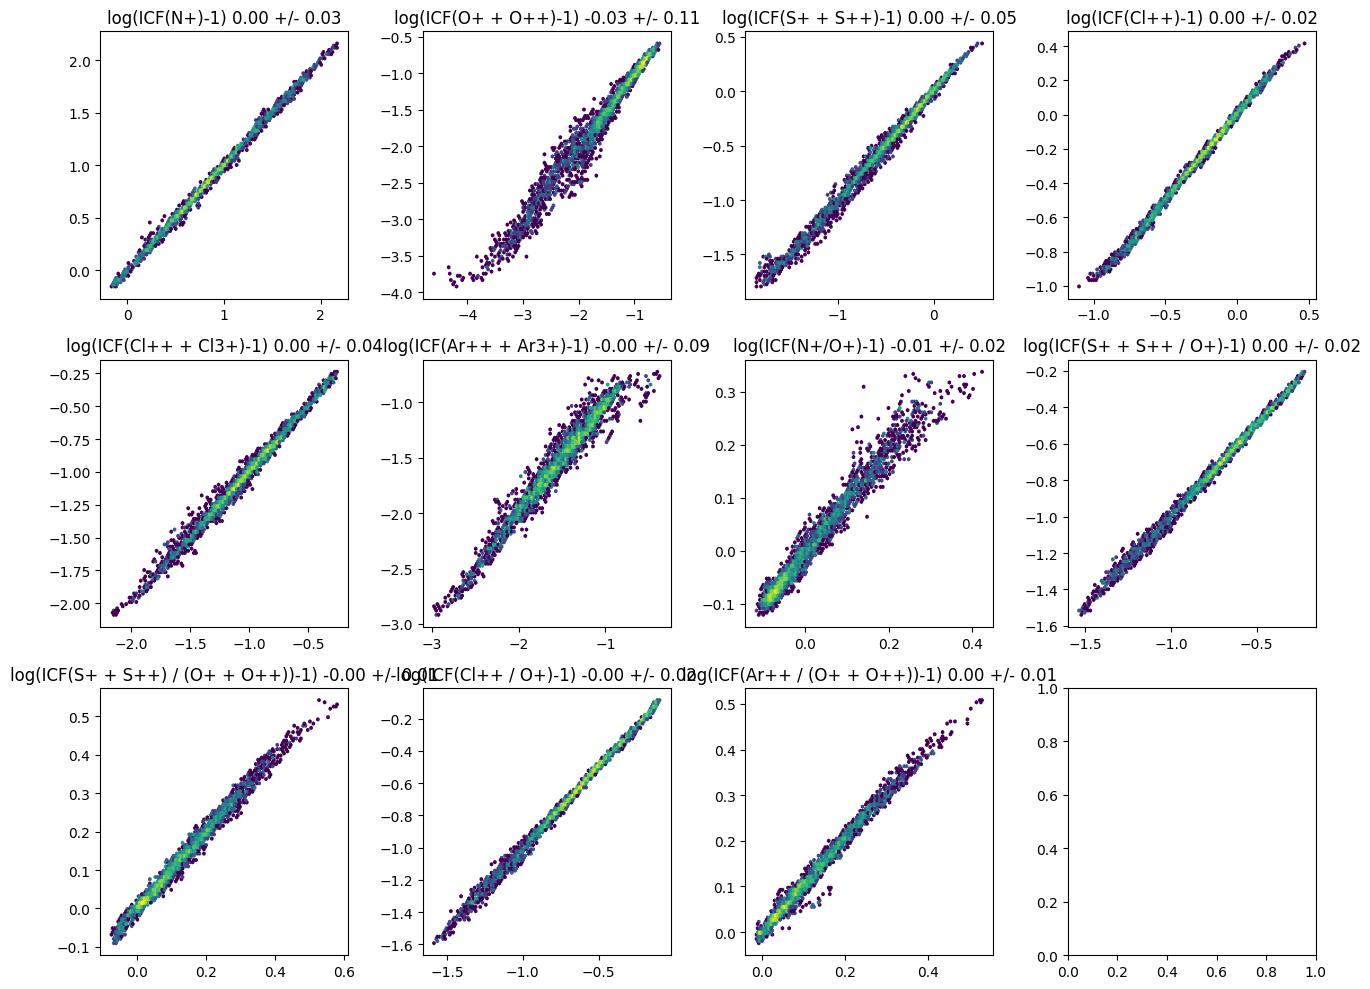

In [21]:
f, axes = plt.subplots(3, 4, figsize=(13, 10))

for i, y_str in enumerate(y_strs):
    diff = (RM.pred - RM.y_test.values)[:, i]
    mean = np.mean(diff)
    std = np.std(diff)
    ax = axes.ravel()[i]
    ax.hexbin(RM.y_test.values[:, i], RM.pred[:, i], bins="log")
    ax.set_title(f"log({ICF_str[y_str[2:]]}-1) {mean:.2f} +/- {std:.2f}")
    print(f"log({ICF_str[y_str[2:]]}-1) {mean:.2f} +/- {std:.2f}")
f.tight_layout()

## Apply ML to the observations

In [22]:
def get_ab_ratio(label1,label2):
    ab1 = abund_r7[label1]
    ab2 = abund_r7[label2]
    return ab2/(ab1+ab2)

In [23]:
# Calculo He+/H+ de la zona warm
pn.atomicData.setDataFile('he_i_rec_S96_caseB.hdf5')
    
omega = joblib.load('omega_mask.joblib')[0]
omega_1 = joblib.load('omega_1_mask.joblib')[0]

he1 = pn.RecAtom('He', 1)
he2 = pn.RecAtom('He', 2)
e_72 = lambda T, den: he1.getEmissivity(tem=T, den=den, label='7281.0') / getHbEmissivity(T, den) 
e_66 = lambda T, den: he1.getEmissivity(tem=T, den=den, label='6678.0') / getHbEmissivity(T, den) 
Hb = obs_int.getLine(label='H1r_4861A').corrIntens
I_66 = obs_int.getLine(label='He1r_6678A').corrIntens/Hb
I_72 = obs_int.getLine(label='He1r_7281A').corrIntens/Hb
T_w, T_c = 8300, 2000
dens_w, dens_c = 3e3, 1e4

e_66_w = e_66(T_w, dens_w)
e_66_c = e_66(T_c, dens_c)
e_72_w = e_72(T_w, dens_w)
e_72_c = e_72(T_c, dens_c)

Hep_w = (I_66 - I_72 * e_66_c/e_72_c) / (omega_1) / (e_66_w - e_72_w/e_72_c*e_66_c)
Hep_c = (I_66 - I_72 * e_66_w/e_72_w) / omega / (e_66_c - e_72_c/e_72_w*e_66_w)

In [24]:
Hep_w[0], np.mean(Hep_w), np.quantile(Hep_w,0.16), np.quantile(Hep_w,0.84)

(0.08908079920395719,
 0.08998018255658284,
 0.07469616782761361,
 0.105230951822565)

In [25]:
np.log10(0.0892)+12, np.log10(0.006)+12

(10.950364854376122, 9.778151250383644)

(-0.02, 0.18)

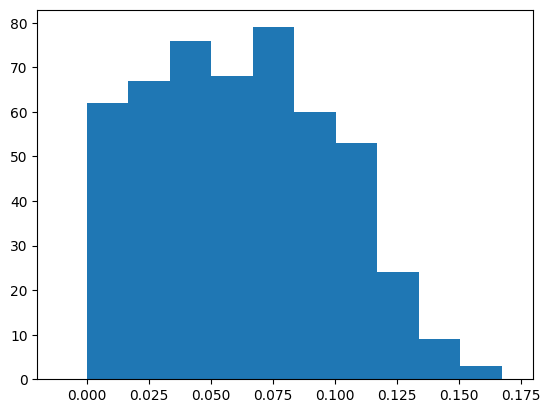

In [26]:
np.random.seed(123)
Hepp = 0.012*np.random.rand(501) 
ahe21 = Hepp/(Hep_w+Hepp)
plt.hist(ahe21)
plt.xlim(-0.02,0.18)

In [27]:
ahe21[0] = 0.006 / (0.0892 + 0.006)

In [28]:
obs_mc = {"ahe21": ahe21, # He++/H+ (warm): valores aleatorios entre el minimo 0 y el maximo 0.012.
          "ao21":get_ab_ratio('O2_7330A+','O3_4959A'), 
          "as21":get_ab_ratio('S2_6731A', 'S3_9069A'), 
          "acl32":get_ab_ratio('Cl3_5538A', 'Cl4_8046A'), 
          "aar32":get_ab_ratio('Ar3_7136A', 'Ar4_4740A')
         }

X_obs = np.asarray([obs_mc[k] for k in X_strs])
N_obs = X_obs.shape[1]
X_obs

array([[0.06302521, 0.03247197, 0.03706205, ..., 0.03648763, 0.07963168,
        0.02721607],
       [0.91564083, 0.92163834, 0.91399206, ..., 0.92949722, 0.90377936,
        0.90135874],
       [0.93660658, 0.94125986, 0.95873508, ..., 0.92353922, 0.93643188,
        0.92008221],
       [0.23899591, 0.25543377, 0.21135798, ..., 0.24444037, 0.25658329,
        0.24479167],
       [0.23968329, 0.22404661, 0.23407744, ..., 0.24171404, 0.25587099,
        0.2457575 ]])

In [29]:
X_obs.shape

(5, 501)

In [30]:
RM.set_test(X_obs.T)

Test data scaled. 
Training set size = 16756, Test set size = 501


/home/vero/.cache/pypoetry/virtualenvs/ngc-muse-afNZkvwp-py3.10/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
RM.predict()

Predicting from 5 inputs to 11 outputs using 501 data in 0.00 secs.


In [32]:
ICF_dict = {'ANN':{},'DI14':{}, 'look_up': {}}
for i,y_str in enumerate(y_strs):
    if 'O' in y_str:
        ICF_dict['ANN'][y_str[2:]] = 10**RM.pred[:,i]
    else:
        ICF_dict['ANN'][y_str[2:]] = 1+10**RM.pred[:,i]
    
    x = df[mask][y_str[2:]]
    d_l = np.quantile(x,0.5) - np.quantile(x,0.16)
    d_h = np.quantile(x,0.84) - np.quantile(x,0.5)

    np.random.seed(123)
    error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
    error[0] = 0
    ICF_dict['look_up'][y_str[2:]] = np.quantile(x, 0.5) + error

In [33]:
ICF_dict['ANN'].keys()

dict_keys(['in1', 'io21', 'is21', 'icl2', 'icl32', 'iar32', 'inO1', 'isO21', 'is21O21', 'iclO2', 'iarO2'])

In [34]:
np.median(ICF_dict['ANN']['in1']),np.median(ICF_dict['ANN']['inO1'])

(14.687038362690332, 1.2693625543443492)

In [35]:
nu = ahe21  # He++ / (He+ + He++)
omeg = get_ab_ratio('O2_7330A+','O3_4959A')  # O++ / (O+ + O++)

print(f'Omeg = {omeg[0]:.2f}, nu = {nu[0]:.3f}')

Omeg = 0.92, nu = 0.063


In [36]:
USE_MEDIAN = True

In [37]:
y_str = 'io21'
use_median = USE_MEDIAN

ICF = 10**((0.08*nu + 0.006*nu**2)/(0.34 - 0.27*nu))
d_l = ICF * .03+0.5*nu-0.2*nu**2

np.random.seed(123)
error = d_l*np.random.randn(501) #Distribución normal para el error porque es simétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(O+ + O++) : 1.03+0.07-0.06 


In [38]:
y_str = 'inO1'
use_median = USE_MEDIAN

ICF = 10**(-0.16 * omeg * (1+np.log10(nu)))
d_l = 0.32 * ICF
d_h = 0.5 * ICF

np.random.seed(123)
error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(N+/O+) : 1.16+0.21-0.12 


In [39]:
y_str = 'isO21'
use_median = USE_MEDIAN

ICF = 10**((-0.02 - 0.03*omeg-2.31*omeg**2+2.19*omeg**3)/(0.69+2.09*omeg-2.69*omeg**2))
d_l = 0.2 * ICF
d_h = 0.12 * ICF

np.random.seed(123)
error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(S+ + S++ / O+) : 0.13+0.03-0.02 


In [40]:
y_str = 'iarO2'
use_median = USE_MEDIAN

ICF = 10**(0.03*omeg/(0.4-0.3*omeg) - 0.05)
d_l = 0.7 * ICF
d_h = 0.6 * ICF

np.random.seed(123)
error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(Ar++ / (O+ + O++)) : 1.36+0.66-0.58 


In [41]:
y_str = 'ico'
use_median = USE_MEDIAN

ICF = (0.005 + 2.21*omeg -2.77*omeg**2 + 1.74*omeg**3)
d_l = 0.19 * ICF
d_h = (0.4 - 1.06*omeg + 0.65*omeg**2 + 0.27*omeg**3)* ICF

np.random.seed(123)
error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"ICF(C++/O++) : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(C++/O++) : 1.02+0.14-0.12 


In [42]:
y_str = 'iclO2'
use_median = USE_MEDIAN

ICF = (4.162 - 4.1622*omeg**0.21)**0.75
d_l = 0.27 * ICF
d_h = 0.15 * ICF

np.random.seed(123)
error = (-d_l + (d_h+d_l)*np.random.rand(501)) #Distribución uniforme para el error porque es asimétrico
error[0] = 0
ICF_we = ICF + error

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(Cl++ / O+) : 0.14+0.04-0.03 


In [43]:
y_str = 'ikr3'
use_median = USE_MEDIAN

ar4_ar = get_ab_ratio('Ar3_7136A', 'Ar4_4740A') / ICF_dict['ANN']['iar32']
ICF_we = 1./(0.06681 + 1.05*ar4_ar + 0.7112*ar4_ar**2 - 0.907*ar4_ar**3 ) #Este ICF no tiene error asociado

ICF_dict['DI14'][y_str] = ICF_we

if use_median:
    central_ICF = np.median(ICF_we)
else:
    central_ICF = ICF_we[0]
    
err_up = np.quantile(ICF_we,0.84) - central_ICF
err_down = central_ICF - np.quantile(ICF_we,0.16)

print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

ICF(Kr3+) : 2.96+0.26-0.23 


In [44]:
def print_icf(method, y_str):
    icf = ICF_dict[method][y_str]

    central_ICF = np.median(icf)

    err_up = np.quantile(icf,0.84) - central_ICF
    err_down = central_ICF - np.quantile(icf,0.16)

    print(f"{ICF_str[y_str]} : {central_ICF:.2f}+{err_up:.2f}-{err_down:.2f} ")

In [45]:
print('ICF para DI14')
for y_str in ICF_dict['DI14']:
    print_icf('DI14',y_str)

ICF para DI14
ICF(O+ + O++) : 1.03+0.07-0.06 
ICF(N+/O+) : 1.16+0.21-0.12 
ICF(S+ + S++ / O+) : 0.13+0.03-0.02 
ICF(Ar++ / (O+ + O++)) : 1.36+0.66-0.58 
ICF(C+/O+) : 1.02+0.14-0.12 
ICF(Cl++ / O+) : 0.14+0.04-0.03 
ICF(Kr3+) : 2.96+0.26-0.23 


In [46]:
print('ICF para look up table')
for y_str in ICF_dict['look_up']:
    print_icf('look_up',y_str)

ICF para look up table
ICF(N+) : 12.72+1.43-1.17 
ICF(O+ + O++) : 1.01+0.01-0.01 
ICF(S+ + S++) : 1.34+0.04-0.03 
ICF(Cl++) : 1.38+0.03-0.02 
ICF(Cl++ + Cl3+) : 1.05+0.01-0.00 
ICF(Ar++ + Ar3+) : 1.01+0.00-0.00 
ICF(N+/O+) : 1.24+0.08-0.07 
ICF(S+ + S++ / O+) : 0.13+0.02-0.01 
ICF(S+ + S++) / (O+ + O++)) : 1.33+0.04-0.04 
ICF(Cl++ / O+) : 0.13+0.02-0.01 
ICF(Ar++ / (O+ + O++)) : 1.29+0.02-0.02 


In [47]:
print('ICF para ANN')
for y_str in ICF_dict['ANN']:
    print_icf('ANN',y_str)

ICF para ANN
ICF(N+) : 14.69+3.06-2.97 
ICF(O+ + O++) : 1.04+0.02-0.02 
ICF(S+ + S++) : 1.31+0.06-0.04 
ICF(Cl++) : 1.41+0.05-0.04 
ICF(Cl++ + Cl3+) : 1.05+0.01-0.01 
ICF(Ar++ + Ar3+) : 1.01+0.00-0.00 
ICF(N+/O+) : 1.27+0.13-0.12 
ICF(S+ + S++ / O+) : 0.11+0.03-0.02 
ICF(S+ + S++) / (O+ + O++)) : 1.32+0.07-0.06 
ICF(Cl++ / O+) : 0.12+0.03-0.02 
ICF(Ar++ / (O+ + O++)) : 1.32+0.08-0.09 


In [48]:
# We set the ionic abundances 

Np = abund_r7['N2_6548A']
Sp = abund_r7['S2_6731A'] 
Spp = abund_r7['S3_9069A'] 
Clpp = abund_r7['Cl3_5538A'] 
Cl3p = abund_r7['Cl4_8046A'] 
Op = abund_r7['O2_7330A+'] 
Opp = abund_r7['O3_4959A'] 
O = (Op+Opp)*ICF_dict['DI14']['io21'] 
Ar2p = abund_r7['Ar3_7136A'] 
Ar3p = abund_r7['Ar4_4740A'] 
Oprl = abund_r7['O1r_7773+'] 
Opprl = abund_r7['O2r_4649.13A']
Cpprl = abund_r7['C2r_6462.0A'] 
Kr3p = abund_r7['Kr4_5868A']

abund_dict = {}

#Oxygen
y_str = 'io21'

O_DI14 = 12 + np.log10(ICF_dict['DI14'][y_str]*(Op + Opp))
O_ANN = 12 + np.log10(ICF_dict['ANN'][y_str]*(Op + Opp))
O_look_up = 12 + np.log10(ICF_dict['look_up'][y_str]*(Op + Opp))

abund_dict[y_str] = {'ANN':O_ANN, 'DI14':O_DI14, 'look_up':O_look_up}

#Nitrogen
y_str = 'in1'

N_ANN_1 = 12+np.log10(ICF_dict['ANN'][y_str]*Np)
N_look_up_1 = 12+np.log10(ICF_dict['look_up'][y_str]*Np)

abund_dict[y_str] = {'ANN':N_ANN_1, 'look_up':N_look_up_1}

y_str = 'inO1'

N_DI14 = np.log10(ICF_dict['DI14'][y_str]*(Np/Op)) + O_DI14
N_ANN_2 = np.log10(ICF_dict['ANN'][y_str]*(Np/Op)) + O_ANN
N_look_up_2 = np.log10(ICF_dict['look_up'][y_str]*(Np/Op)) + O_look_up

abund_dict[y_str] = {'ANN':N_ANN_2, 'DI14':N_DI14, 'look_up':N_look_up_2}

#Sulfur
y_str = 'isO21'

S_DI14 = np.log10(ICF_dict['DI14'][y_str]*((Sp + Spp)/Op)) + O_DI14
S_ANN_1 = np.log10(ICF_dict['ANN'][y_str]*((Sp + Spp)/Op)) + O_ANN
S_look_up_1 = np.log10(ICF_dict['look_up'][y_str]*((Sp + Spp)/Op)) + O_look_up

abund_dict[y_str] = {'ANN':S_ANN_1, 'DI14':S_DI14, 'look_up':S_look_up_1}


y_str = 'is21'

S_ANN_2 = 12 + np.log10(ICF_dict['ANN'][y_str]*(Sp + Spp)) 
S_look_up_2 = 12 + np.log10(ICF_dict['look_up'][y_str]*(Sp + Spp)) 

abund_dict[y_str] = {'ANN':S_ANN_2, 'look_up':S_look_up_2}

y_str = 'is21O21'

S_ANN_3 = np.log10(ICF_dict['ANN'][y_str]*((Sp + Spp)/(Op+Opp) )) + O_ANN
S_look_up_3 = np.log10(ICF_dict['look_up'][y_str]*((Sp + Spp)/(Op+Opp))) + O_look_up

abund_dict[y_str] = {'ANN':S_ANN_3, 'look_up':S_look_up_3}

#Argon
y_str = 'iar32'

Ar_ANN_1 = 12 + np.log10(ICF_dict['ANN'][y_str]*(Ar2p + Ar3p)) #ICF((Ar2+ + Ar3+)/H+)
Ar_look_up_1 = 12 + np.log10(ICF_dict['look_up'][y_str]*(Ar2p + Ar3p)) #ICF((Ar2+ + Ar3+)/H+)

abund_dict[y_str] = {'ANN':Ar_ANN_1, 'look_up':Ar_look_up_1}


y_str = 'iarO2'

Ar_DI14 = np.log10((ICF_dict['DI14'][y_str]*(Ar2p/(Op + Opp)))) + O_DI14
Ar_ANN_2 = np.log10((ICF_dict['ANN'][y_str]*(Ar2p/(Op + Opp)))) + O_ANN  #ICF(Ar2+/(O+ + O2+))
Ar_look_up_2 = np.log10((ICF_dict['look_up'][y_str]*(Ar2p/(Op + Opp)))) + O_look_up #ICF(Ar2+/(O+ + O2+))

abund_dict[y_str] = {'ANN':Ar_ANN_2, 'DI14':Ar_DI14, 'look_up':Ar_look_up_2}

#Chlorine
y_str = 'iclO2'

Cl_DI14 = np.log10((ICF_dict['DI14'][y_str]*(Clpp)/Op)) + O_DI14
Cl_ANN_1 = np.log10(ICF_dict['ANN'][y_str]*Clpp/Op) + O_ANN
Cl_look_up_1 = np.log10(ICF_dict['look_up'][y_str]*Clpp/Op) + O_look_up

abund_dict[y_str] = {'ANN':Cl_ANN_1, 'DI14':Cl_DI14, 'look_up':Cl_look_up_1}

y_str = 'icl2'

Cl_ANN_2 = 12 + np.log10(ICF_dict['ANN'][y_str]*(Clpp))
Cl_look_up_2 = 12 + np.log10(ICF_dict['look_up'][y_str]*(Clpp))

abund_dict[y_str] = {'ANN':Cl_ANN_2, 'look_up':Cl_look_up_2}

y_str = 'icl32'

Cl_ANN_3 = 12 + np.log10(ICF_dict['ANN'][y_str]*(Clpp + Cl3p))
Cl_look_up_3 = 12 + np.log10(ICF_dict['look_up'][y_str]*(Clpp + Cl3p))

abund_dict[y_str] = {'ANN':Cl_ANN_3, 'look_up':Cl_look_up_3}

#Kripton
y_str = 'ikr3'

Kr_DI14 = 12 + np.log10(ICF_dict['DI14'][y_str]*Kr3p)

abund_dict[y_str] = {'DI14':Kr_DI14}

#----------------------Recombination lines------------------------------

#Oxygen
y_str = 'rio21'
Orl_DI14 = 12 + np.log10(ICF_dict['DI14'][y_str[1:]]*(Oprl + Opprl))
abund_dict[y_str] = {'DI14':Orl_DI14}

y_str = 'ico'
Crl_DI14 = np.log10(ICF_dict['DI14'][y_str]*(Cpprl/Opprl)) + Orl_DI14
abund_dict[y_str] = {'DI14':Crl_DI14}

In [49]:
abund_dict.keys()

dict_keys(['io21', 'in1', 'inO1', 'isO21', 'is21', 'is21O21', 'iar32', 'iarO2', 'iclO2', 'icl2', 'icl32', 'ikr3', 'rio21', 'ico'])

In [50]:
ICF_dict['DI14'].keys()

dict_keys(['io21', 'inO1', 'isO21', 'iarO2', 'ico', 'iclO2', 'ikr3'])

In [51]:
def get_mean(m1,m2,m3):
    i = 0
    m = 0
    if m1:
        m = m + m1
        i = i + 1
    if m2:
        m = m + m2
        i = i + 1
    if m3:
        m = m + m3
        i = i + 1
    return m/i

In [65]:
def plot_abund(elem, y_str, bins = 30, vline_max = 8):
    colors = ['blue', 'orange', 'green']

    ab = abund_dict[y_str]
    m_a = None
    m_l = None
    m_d = None
    
    fig, ax  = plt.subplots(figsize = (6,5))
    plt.rcParams['font.size'] = 14
    
    if 'ANN' in ab:
        ax.hist(ab['ANN'], color = colors[1], bins = bins, alpha = 0.5, label = 'ANN', density = True)
        m_a = np.median(ab['ANN'])
        ax.vlines(m_a, 0, vline_max, color = colors[1], ls = '-')

    if 'look_up' in ab:
        ax.hist(ab['look_up'], color = colors[2], bins = bins, alpha = 0.5, label = 'look_up', density = True)
        m_l = np.median(ab['look_up'])
        ax.vlines(m_l, 0, vline_max, color = colors[2], ls = '-')

    if 'DI14' in ab:
        ax.hist(ab['DI14'], color = colors[0], bins = bins, alpha = 0.5, label = 'DI14', density = True)
        m_d = np.median(ab['DI14'])
        ax.vlines(m_d, 0, vline_max, color = colors[0], ls = '-')
        
    m = get_mean(m_a, m_l, m_d)
    ax.set_xlim(m-0.35,m+0.35)
    ax.set_ylim(0, vline_max)
    plt.title(f'12+log({elem}/H) with {ICF_str[y_str]}')
    plt.legend()
    fig.savefig("paper_figures/ab_{}_{}.pdf".format(elem,y_str));

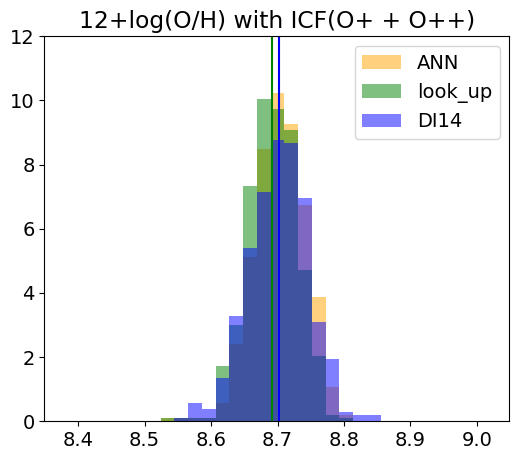

In [66]:
plot_abund('O', 'io21', bins = np.linspace(8.4,9,30), vline_max = 12)

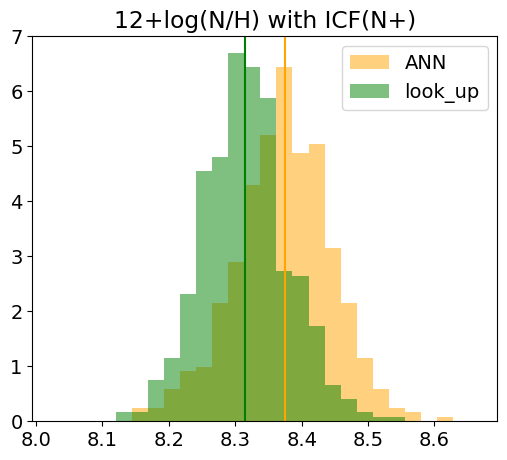

In [67]:
plot_abund('N', 'in1', bins = np.linspace(8,8.7,30), vline_max = 7)

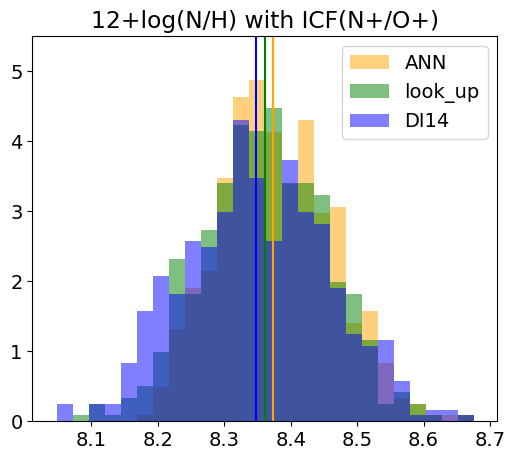

In [68]:
plot_abund('N', 'inO1', bins = np.linspace(8.0,8.7,30), vline_max = 5.5)

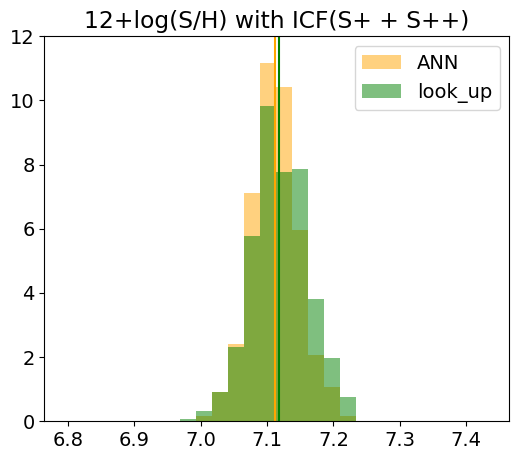

In [69]:
plot_abund('S', 'is21', bins = np.linspace(6.8, 7.5, 30), vline_max = 12)

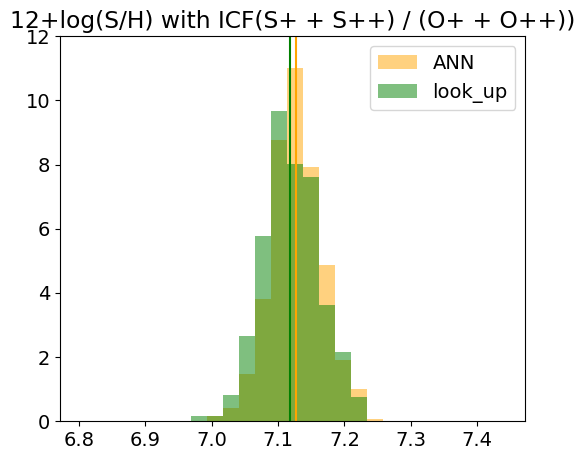

In [70]:
plot_abund('S', 'is21O21', bins = np.linspace(6.8, 7.5, 30), vline_max = 12)

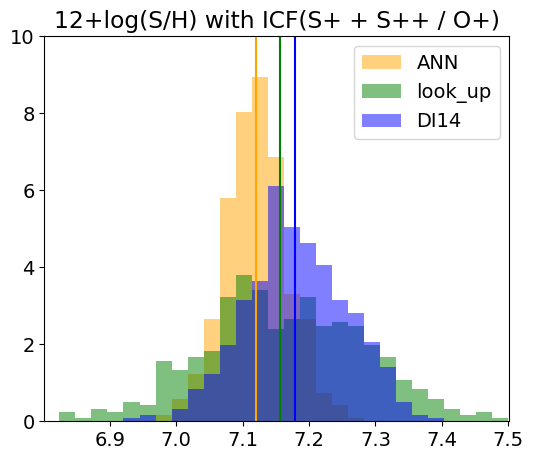

In [71]:
plot_abund('S', 'isO21', bins = np.linspace(6.8, 7.5, 30), vline_max = 10)

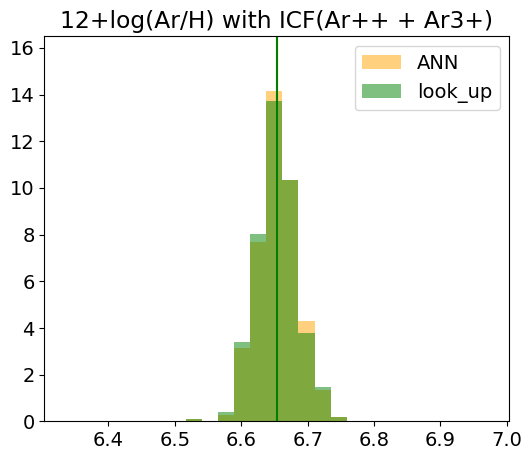

In [73]:
plot_abund('Ar', 'iar32', bins = np.linspace(6.3, 7, 30), vline_max = 16.5)

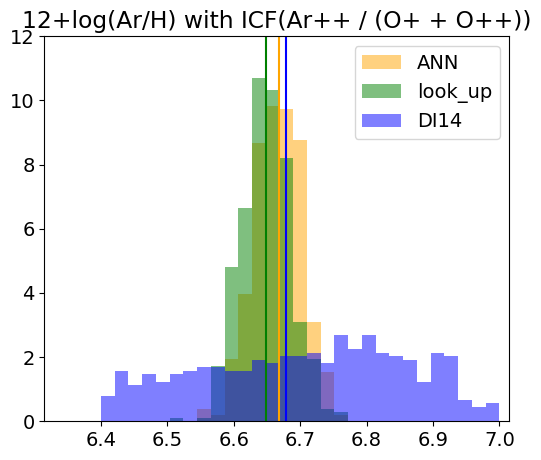

In [76]:
plot_abund('Ar', 'iarO2', bins = np.linspace(6.4, 7, 30), vline_max = 12)

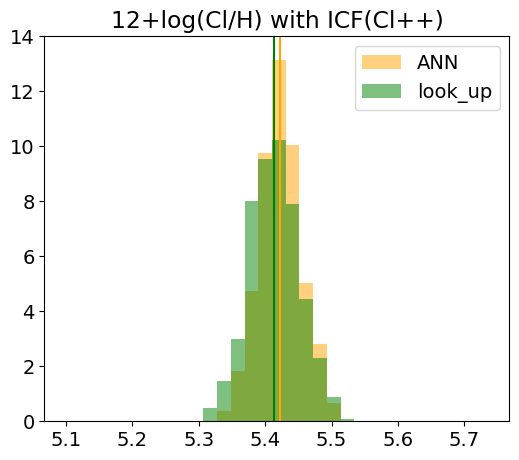

In [77]:
plot_abund('Cl', 'icl2', bins = np.linspace(5.1,5.7,30), vline_max=14)

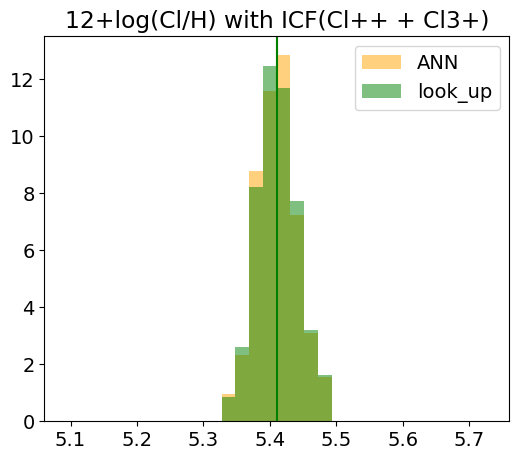

In [79]:
plot_abund('Cl', 'icl32', bins = np.linspace(5.1,5.7,30), vline_max=13.5)

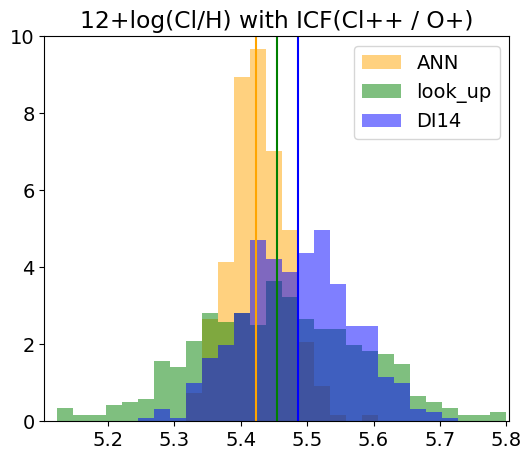

In [81]:
plot_abund('Cl', 'iclO2', bins = np.linspace(5.1,5.8,30), vline_max=10)

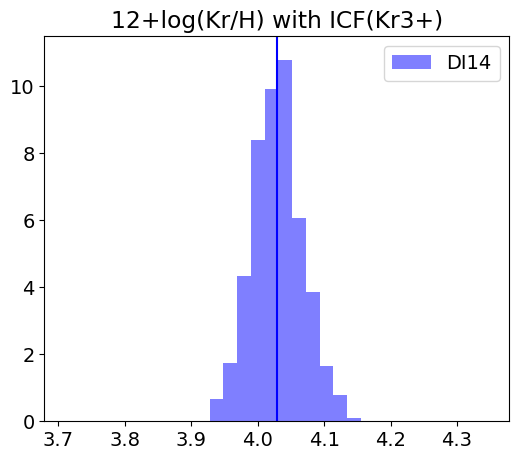

In [85]:
plot_abund('Kr', 'ikr3', bins = np.linspace(3.7,4.3,30), vline_max=11.5)

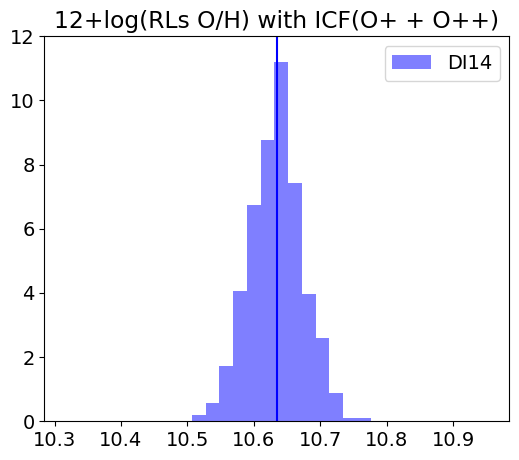

In [87]:
plot_abund('RLs O', 'rio21', bins = np.linspace(10.3,10.9,30), vline_max=12)

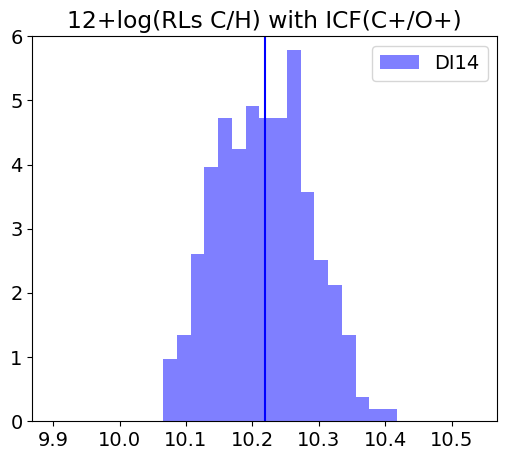

In [89]:
plot_abund('RLs C', 'ico', bins = np.linspace(9.9,10.5,30), vline_max=6)

In [121]:
def get_stats(data):
    med = np.median(data)
    low = np.quantile(data, 0.16)
    up = np.quantile(data, 0.84)
    return med, up - med, med - low

In [123]:
print(f"ICF                         DI14      Look-up Table      ANN")
print(f"-------------------------------------------------------------------")

y_str = 'ico'
ab_D = get_stats(abund_dict[y_str]['DI14'])
print(f"{ICF_str[y_str]} ORLs:        {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  &     --- &      --- ")

y_str = 'io21'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]} CELs:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )

y_str = 'rio21'
ab_D = get_stats(abund_dict[y_str]['DI14'])
print(f"{ICF_str[y_str]} ORLs:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  &     --- &      --- ")

y_str = 'in1'
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:                             --- & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )

y_str = 'inO1'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )

y_str = 'is21'

ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       ---  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'isO21'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )

y_str = 'is21O21'
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:     --- & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'icl2'
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:      --- & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'icl32'
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:      ---  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'iclO2'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'iar32'
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       --- & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'iarO2'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
ab_A = get_stats(abund_dict[y_str]['ANN'])
ab_L = get_stats(abund_dict[y_str]['look_up'])
print(f"{ICF_str[y_str]}:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & {ab_L[0]:.2f}$+^{{{ab_L[1]:.2f}}}_{{{-ab_L[2]:.2f}}}$   &  {ab_A[0]:.2f}$+^{{{ab_A[1]:.2f}}}_{{{-ab_A[2]:.2f}}}$  " )


y_str = 'ikr3'
ab_D = get_stats(abund_dict[y_str]['DI14']) 
print(f"{ICF_str[y_str]}:       {ab_D[0]:.2f}$+^{{{ab_D[1]:.2f}}}_{{{-ab_D[2]:.2f}}}$  & ---  &  --- " )

ICF                         DI14      Look-up Table      ANN
-------------------------------------------------------------------
ICF(C+/O+) ORLs:        10.22$+^{0.07}_{-0.08}$  &     --- &      --- 
ICF(O+ + O++) CELs:       8.70$+^{0.04}_{-0.05}$  & 8.69$+^{0.04}_{-0.03}$   &  8.70$+^{0.04}_{-0.04}$  
ICF(O+ + O++) ORLs:       10.63$+^{0.04}_{-0.04}$  &     --- &      --- 
ICF(N+):                             --- & 8.31$+^{0.06}_{-0.06}$   &  8.37$+^{0.06}_{-0.07}$  
ICF(N+/O+):       8.35$+^{0.11}_{-0.12}$  & 8.36$+^{0.09}_{-0.09}$   &  8.37$+^{0.09}_{-0.08}$  
ICF(S+ + S++):       ---  & 7.12$+^{0.04}_{-0.04}$   &  7.11$+^{0.03}_{-0.03}$  
ICF(S+ + S++ / O+):       7.18$+^{0.08}_{-0.07}$  & 7.16$+^{0.13}_{-0.11}$   &  7.12$+^{0.05}_{-0.04}$  
ICF(S+ + S++) / (O+ + O++)):     --- & 7.12$+^{0.04}_{-0.04}$   &  7.13$+^{0.04}_{-0.03}$  
ICF(Cl++):      --- & 5.41$+^{0.04}_{-0.04}$   &  5.42$+^{0.03}_{-0.03}$  
ICF(Cl++ + Cl3+):      ---  & 5.41$+^{0.03}_{-0.03}$   &  5.41$+^{0.03}_{-0.